# Session 10 - Unsupervised Learning 

## Contents

- [Principal Components Analysis](#Principal-Components-Analysis)
- [Clustering Methods](#Clustering-Methods)

## Labs

- [Principal Component Analysis](#Lab-1:-Principal-Component-Analysis)
- [Clustering](#Lab-2:-Clustering)
- [NCI60 Data Example](#Lab-3:-NCI60-Data-Example)

In [43]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Principal Components Analysis

TBD

## Clustering Methods

TBD

## Lab 1: Principal Component Analysis

In [3]:
# In R, I exported the dataset to a csv file. It is part of the base R distribution.
df = pd.read_csv('Data/USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [4]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [5]:
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

In [6]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [7]:
# The loading vectors
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=df.columns, columns=['V1', 'V2', 'V3', 'V4'])
pca_loadings

,V1,V2,V3,V4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


In [8]:
# Fit the PCA model and transform X to get the principal components
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
df_plot

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996
Colorado,1.514563,-0.987555,1.095007,0.001465
Connecticut,-1.358647,-1.088928,-0.643258,-0.118469
Delaware,0.047709,-0.325359,-0.718633,-0.881978
Florida,3.013042,0.039229,-0.576829,-0.096285
Georgia,1.639283,1.278942,-0.342460,1.076797


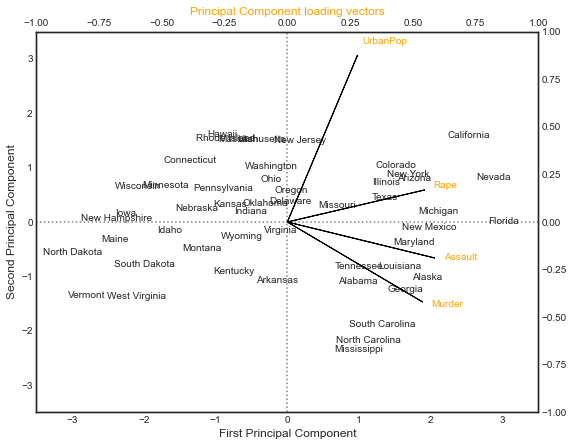

In [9]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='orange')

# Plot vectors
ax2.arrow(0,0,pca_loadings.V1[0], -pca_loadings.V2[0])
ax2.arrow(0,0,pca_loadings.V1[1], -pca_loadings.V2[1])
ax2.arrow(0,0,pca_loadings.V1[2], -pca_loadings.V2[2])
ax2.arrow(0,0,pca_loadings.V1[3], -pca_loadings.V2[3]);

In [10]:
# Standard deviation of the four principal components
np.sqrt(pca.explained_variance_)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

In [11]:
pca.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [12]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

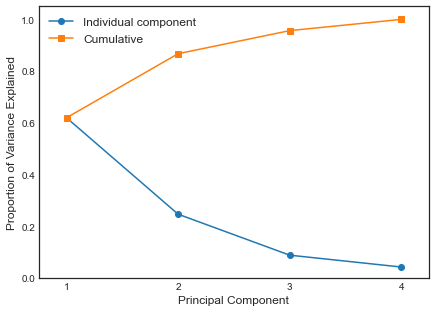

In [13]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2);

## Lab 2: Clustering

### Lab 2.1: K-Means Clustering

The `sklearn` function `Kmeans()` performs K-means clustering in R. We begin with
a simple simulated example in which there truly are two clusters in the
data: the first 25 observations have a mean shift relative to the next 25
observations.

Text(0, 0.5, 'X1')

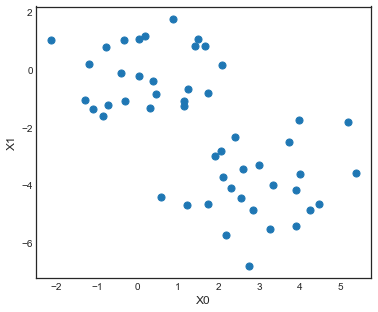

In [14]:
np.random.seed(123)
X = np.random.randn(50,2)
X[0:25, 0] = X[0:25, 0] + 3
X[0:25, 1] = X[0:25, 1] - 4

f, ax = plt.subplots(figsize=(6, 5))
ax.scatter(X[:,0], X[:,1], s=50) 
ax.set_xlabel('X0')
ax.set_ylabel('X1')

We now perform K-means clustering with `K = 2`:

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, random_state = 123).fit(X)

The cluster assignments of the 50 observations are contained in
`kmeans.labels_`:

In [16]:
print(kmeans.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


The K-means clustering perfectly separated the observations into two clusters
even though we did not supply any group information to `Kmeans()`. We
can plot the data, with each observation colored according to its cluster
assignment:

Text(0, 0.5, 'X1')

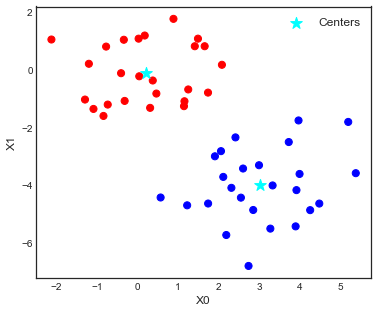

In [17]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s = 50, c = kmeans.labels_, cmap = plt.cm.bwr) 
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            marker = '*', 
            s = 150,
            color = 'cyan', 
            label = 'Centers')
plt.legend(loc = 'best')
plt.xlabel('X0')
plt.ylabel('X1')

Here the observations can be easily plotted because they are two-dimensional.
If there were more than two variables then we could instead perform PCA
and plot the first two principal components score vectors.

In this example, we knew that there really were two clusters because
we generated the data. However, for real data, in general we do not know
the true number of clusters. We could instead have performed K-means
clustering on this example with `K  =  3`. If we do this, K-means clustering will split up the two "real" clusters, since it has no information about them:

Text(0, 0.5, 'X1')

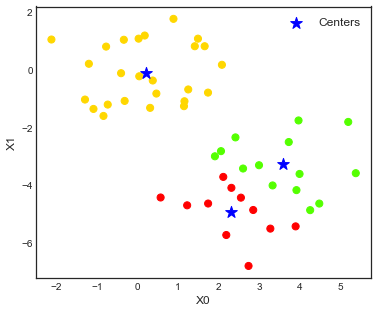

In [18]:
kmeans_3_clusters = KMeans(n_clusters = 3, random_state = 123)
kmeans_3_clusters.fit(X)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=50, c=kmeans_3_clusters.labels_, cmap=plt.cm.prism) 
plt.scatter(kmeans_3_clusters.cluster_centers_[:, 0], kmeans_3_clusters.cluster_centers_[:, 1], marker='*', s=150,
            color='blue', label='Centers')
plt.legend(loc='best')
plt.xlabel('X0')
plt.ylabel('X1')

To run the `Kmeans()` function in python with multiple initial cluster assignments,
we use the `n_init` argument (default: 10). If a value of `n_init` greater than one
is used, then K-means clustering will be performed using multiple random
assignments, and the `Kmeans()` function will
report only the best results. Here we compare using `n_init = 1`:

In [19]:
km_out_single_run = KMeans(n_clusters = 3, n_init = 1, random_state = 123).fit(X)
km_out_single_run.inertia_

99.66252501749231

to `n_init = 20`:

In [20]:
km_out_single_run = KMeans(n_clusters = 3, n_init = 20, random_state = 123).fit(X)
km_out_single_run.inertia_

98.83395271281782

Note that `.inertia_` is the total within-cluster sum of squares,
which we seek to minimize by performing K-means clustering.

It is generally recommended to always run K-means clustering with a large
value of `n_init`, such as 20 or 50 to avoid getting stuck in an undesirable local
optimum.

When performing K-means clustering, in addition to using multiple initial
cluster assignments, it is also important to set a random seed using the
`random_state` parameter. This way, the initial cluster assignments can
be replicated, and the K-means output will be fully reproducible.

### Lab 2.2: Hierarchical Clustering

The `linkage()` function from `scipy` implements several clustering functions in python. In the following example we use the data from the previous section to plot the hierarchical
clustering dendrogram using complete, single, and average linkage clustering,
with Euclidean distance as the dissimilarity measure. We begin by
clustering observations using complete linkage:

In [21]:
from scipy.cluster.hierarchy import linkage

hc_complete = linkage(X, "complete")

We could just as easily perform hierarchical clustering with average or single linkage instead:

In [22]:
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

We can now plot the dendrograms obtained using the usual `dendrogram()` function.
The numbers at the bottom of the plot identify each observation:

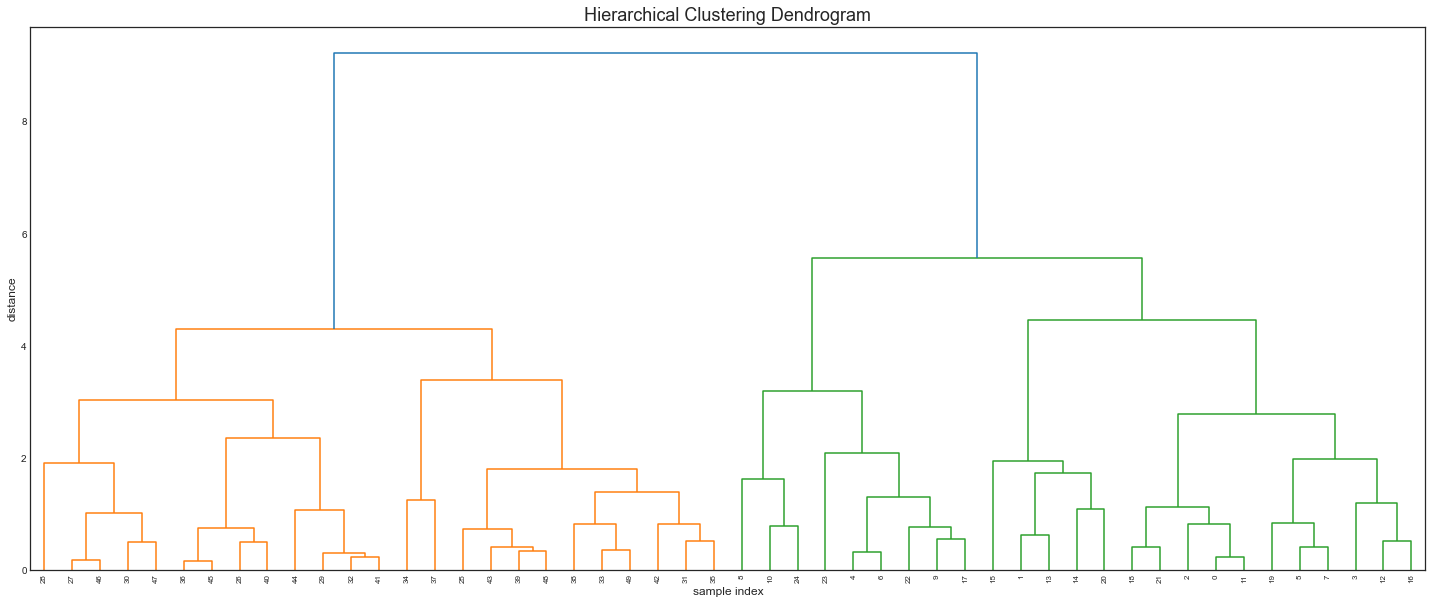

In [23]:
from scipy.cluster.hierarchy import dendrogram

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    hc_complete,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

To determine the cluster labels for each observation associated with a
given cut of the dendrogram, we can use the `cut_tree()` function:

In [24]:
from scipy.cluster.hierarchy import cut_tree
print(cut_tree(hc_complete, n_clusters = 2).T) # Printing transpose just for space

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


For this data, complete and average linkage generally separates the observations
into their correct groups.

## Lab 3: NCI60 Data Example

### Lab 3.1: PCA

In [25]:
# In R, I exported the two elements of this ISLR dataset to csv files.
# There is one file for the features and another file for the classes/types.
df2 = pd.read_csv('data/NCI60_X.csv').drop('Unnamed: 0', axis=1)
df2.columns = np.arange(df2.columns.size)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Columns: 6830 entries, 0 to 6829
dtypes: float64(6830)
memory usage: 3.3 MB


In [26]:
X = pd.DataFrame(scale(df2))
X.shape

(64, 6830)

In [27]:
y = pd.read_csv('data/NCI60_y.csv', usecols=[1], skiprows=1, names=['type'])
y.shape

(64, 1)

In [28]:
y.type.value_counts()

RENAL          9
NSCLC          9
MELANOMA       8
COLON          7
BREAST         7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
MCF7D-repro    1
MCF7A-repro    1
UNKNOWN        1
K562A-repro    1
K562B-repro    1
Name: type, dtype: int64

In [29]:
# Fit the PCA model and transform X to get the principal components
pca2 = PCA()
df2_plot = pd.DataFrame(pca2.fit_transform(X))

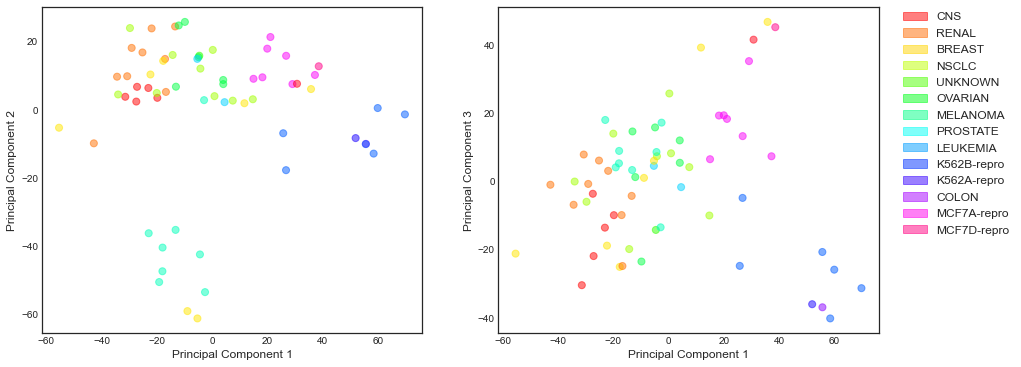

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

color_idx = pd.factorize(y.type)[0]
cmap = plt.cm.hsv

# Left plot
ax1.scatter(df2_plot.iloc[:,0], -df2_plot.iloc[:,1], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax1.set_ylabel('Principal Component 2')

# Right plot
ax2.scatter(df2_plot.iloc[:,0], df2_plot.iloc[:,2], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax2.set_ylabel('Principal Component 3')

# Custom legend for the classes (y) since we do not create scatter plots per class (which could have their own labels).
handles = []
labels = pd.factorize(y.type.unique())
norm = mpl.colors.Normalize(vmin=0.0, vmax=14.0)

for i, v in zip(labels[0], labels[1]):
    handles.append(mpl.patches.Patch(color=cmap(norm(i)), label=v, alpha=0.5))

ax2.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# xlabel for both plots
for ax in fig.axes:
    ax.set_xlabel('Principal Component 1')    

In [32]:
pd.DataFrame([df2_plot.iloc[:,:5].std(axis=0, ddof=0).values,
              pca2.explained_variance_ratio_[:5],
              np.cumsum(pca2.explained_variance_ratio_[:5])],
             index=['Standard Deviation', 'Proportion of Variance', 'Cumulative Proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

,PC1,PC2,PC3,PC4,PC5
Standard Deviation,27.853469,21.481355,19.820465,17.032556,15.971807
Proportion of Variance,0.113589,0.067562,0.057518,0.042476,0.037350
Cumulative Proportion,0.113589,0.181151,0.238670,0.281145,0.318495


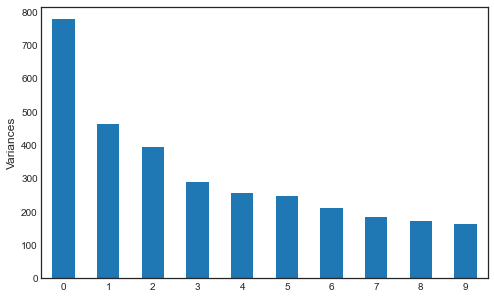

In [33]:
df2_plot.iloc[:,:10].var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances');

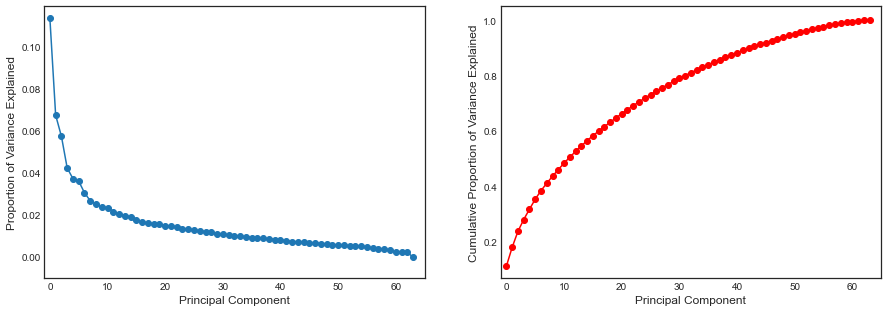

In [34]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Left plot
ax1.plot(pca2.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

# Right plot
ax2.plot(np.cumsum(pca2.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,65)    

### Lab 3.2: Clustering the Observations of the NCI60 Data 

Unsupervised techniques are often used in the analysis of genomic data. In this portion of the lab, we'll see how hierarchical and K-means clustering compare on the `NCI60` cancer cell line microarray data, which
consists of 6,830 gene expression measurements on 64 cancer cell lines:

In [35]:
# The NCI60 data
nci_labs = pd.read_csv("data/NCI60_y.csv", index_col = 0)
nci_data = pd.read_csv("data/NCI60_X.csv", index_col = 0)

Each cell line is labeled with a cancer type. We'll ignore the
cancer types in performing clustering, as these are unsupervised
techniques. After performing clustering, we'll use this column to see the extent to which these cancer types agree with the results of these
unsupervised techniques.

The data has 64 rows and 6,830 columns.

In [36]:
nci_data.shape

(64, 6830)

Let's take a look at the cancer types for the cell lines:

In [37]:
nci_labs.x.value_counts(sort=True)

RENAL          9
NSCLC          9
MELANOMA       8
COLON          7
BREAST         7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
MCF7D-repro    1
MCF7A-repro    1
UNKNOWN        1
K562A-repro    1
K562B-repro    1
Name: x, dtype: int64

# 10.6.2 Clustering the Observations of the NCI60 Data
We now proceed to hierarchically cluster the cell lines in the `NCI60` data,
with the goal of finding out whether or not the observations cluster into
distinct types of cancer.

We now perform hierarchical clustering of the observations using complete,
single, and average linkage. We'll use standard Euclidean distance as the dissimilarity
measure:

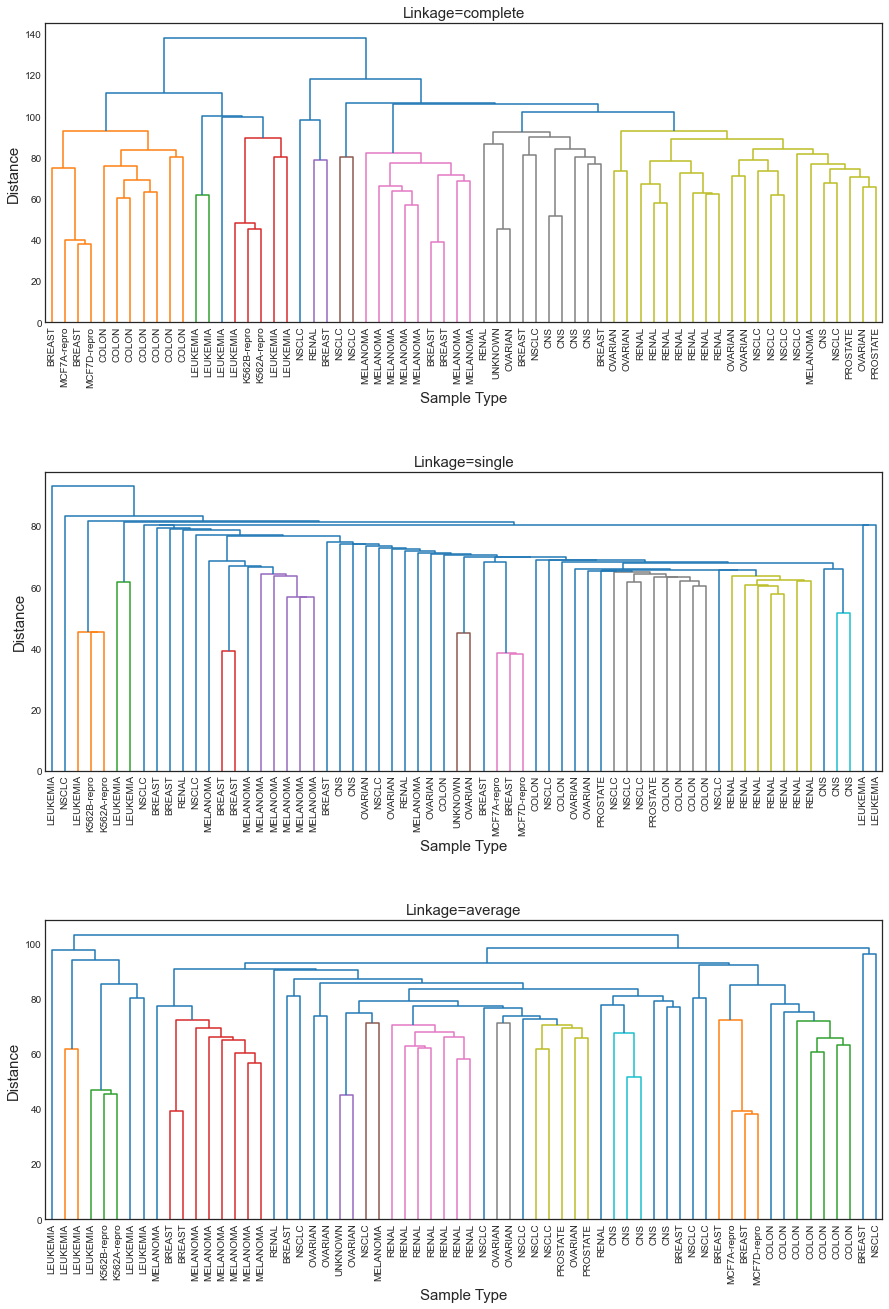

In [38]:
nci_data.index = nci_labs.x

fig, ax = plt.subplots(3,1, figsize=(15,22))
fig.subplots_adjust(hspace=0.5)

linkages = ['complete', 'single', 'average']
for link, axis in zip(linkages, fig.axes):
    hc = linkage(y = nci_data, method=link, metric='euclidean') 
    axis.set_title("Linkage=%s" % link, size=15)
    axis.set_xlabel('Sample Type', size=15)
    axis.set_ylabel('Distance', size=15)
    dendrogram(hc, ax=axis, labels=nci_data.index, leaf_rotation=90, leaf_font_size=10)

We see that the choice of linkage
certainly does affect the results obtained. Typically, single linkage will tend
to yield trailing clusters: very large clusters onto which individual observations
attach one-by-one. On the other hand, complete and average linkage
tend to yield more balanced, attractive clusters. For this reason, complete
and average linkage are generally preferred to single linkage. Clearly cell
lines within a single cancer type do tend to cluster together, although the
clustering is not perfect. 

Let's use our complete linkage hierarchical clustering
for the analysis. We can cut the dendrogram at the height that will yield a particular
number of clusters, say 4:

In [39]:
nci_hc_complete = linkage(y = nci_data, method="complete", metric='euclidean') 

nci_hc_complete_4_clusters = cut_tree(nci_hc_complete, n_clusters = 4) # Printing transpose just for space

pd.crosstab(index = nci_data.index, 
            columns = nci_hc_complete_4_clusters.T[0], 
            rownames = ['Cancer Type'], 
            colnames = ['Cluster'])

Cluster,0,1,2,3
Cancer Type,,,,
BREAST,4,1,0,2
CNS,5,0,0,0
COLON,0,0,0,7
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,0,0,6,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,8,0,0,0


There are some clear patterns. All the leukemia cell lines fall in cluster 2,
while the breast cancer cell lines are spread out over three different clusters.
We can plot the cut on the dendrogram that produces these four clusters by adding an `axhline()`, which draws a horizontal line on top of our plot:

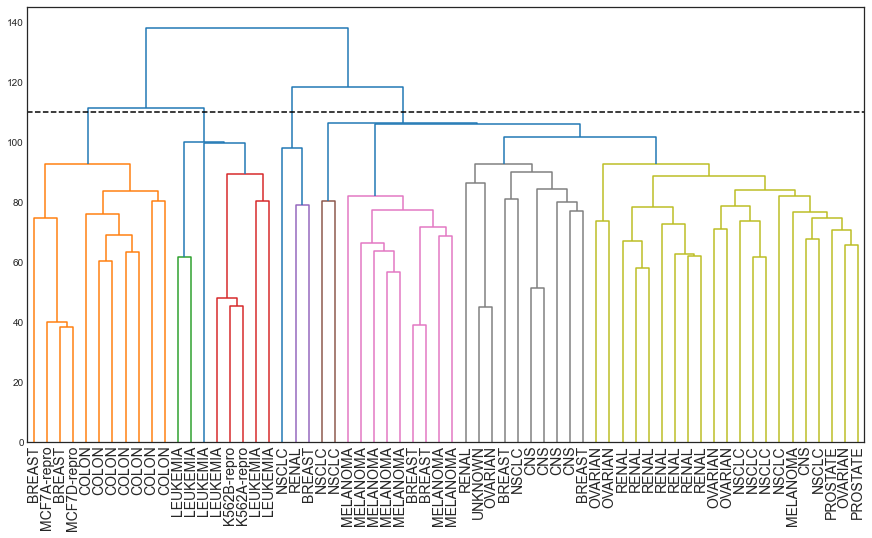

In [40]:
fig, ax = plt.subplots(1,1, figsize = (15,8))
dendrogram(nci_hc_complete, 
           labels = nci_data.index, 
           leaf_font_size = 14, 
           show_leaf_counts = True)  

plt.axhline(y=110, c='k', ls='dashed')
plt.show()

We claimed earlier that K-means clustering and hierarchical
clustering with the dendrogram cut to obtain the same number
of clusters can yield **very** different results. How do these `NCI60` hierarchical
clustering results compare to what we get if we perform K-means clustering
with `K = 4`?

In [41]:
kmean_4 = KMeans(n_clusters = 4, random_state = 123, n_init = 150)    
kmean_4.fit(nci_data)
kmean_4.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int32)

We can use a confusion matrix to compare the differences in how the two methods assigned observations to clusters:

In [42]:
pd.crosstab(index = kmean_4.labels_, 
            columns = nci_hc_complete_4_clusters.T[0], 
            rownames = ['K-Means'], 
            colnames = ['Hierarchical'])

Hierarchical,0,1,2,3
K-Means,,,,
0,8,0,0,11
1,0,0,8,0
2,25,3,0,0
3,9,0,0,0


We see that the four clusters obtained using hierarchical clustering and Kmeans
clustering are somewhat different. Cluster 0 in K-means clustering is almost
identical to cluster 2 in hierarchical clustering. However, the other clusters
differ: for instance, cluster 2 in K-means clustering contains a portion of
the observations assigned to cluster 0 by hierarchical clustering, as well as
all of the observations assigned to cluster 1 by hierarchical clustering.

To get credit for this lab, use a similar analysis to compare the results of your K-means clustering to the results of your hierarchical clustering with single and average linkage. What differences do you notice? Post your response to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=267171